In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.CycGBM import CycGBM
from src.utils import tune_kappa
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from src.distributions import BetaPrimeDistribution

In [2]:
n = 1000
rng = np.random.default_rng(seed=10)
X0 = np.arange(0, n) / n
X1 = np.arange(0, n) / n
rng.shuffle(X1)
mu = np.exp(1 * (X0 > 0.3 * n) + 0.5 * (X1 > 0.5 * n))
v = np.exp(1 + 1 * X0 - 3 * np.abs(X1))

X = np.stack([X0, X1]).T
alpha = mu * (1 + v)
beta = v + 2
y0 = rng.beta(alpha, beta)
y = y0 / (1 - y0)

kappa_max = 1000
eps = 0.1
max_depth = 2
min_samples_leaf = 20
random_state = 5
n_splits = 4

kappa, loss = tune_kappa(
    X=X,
    y=y,
    kappa_max=kappa_max,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="beta_prime",
    n_splits=n_splits,
    random_state=random_state,
)

print(kappa)

[ 8 17]


BOpt mu: 12
BOpt v: 20


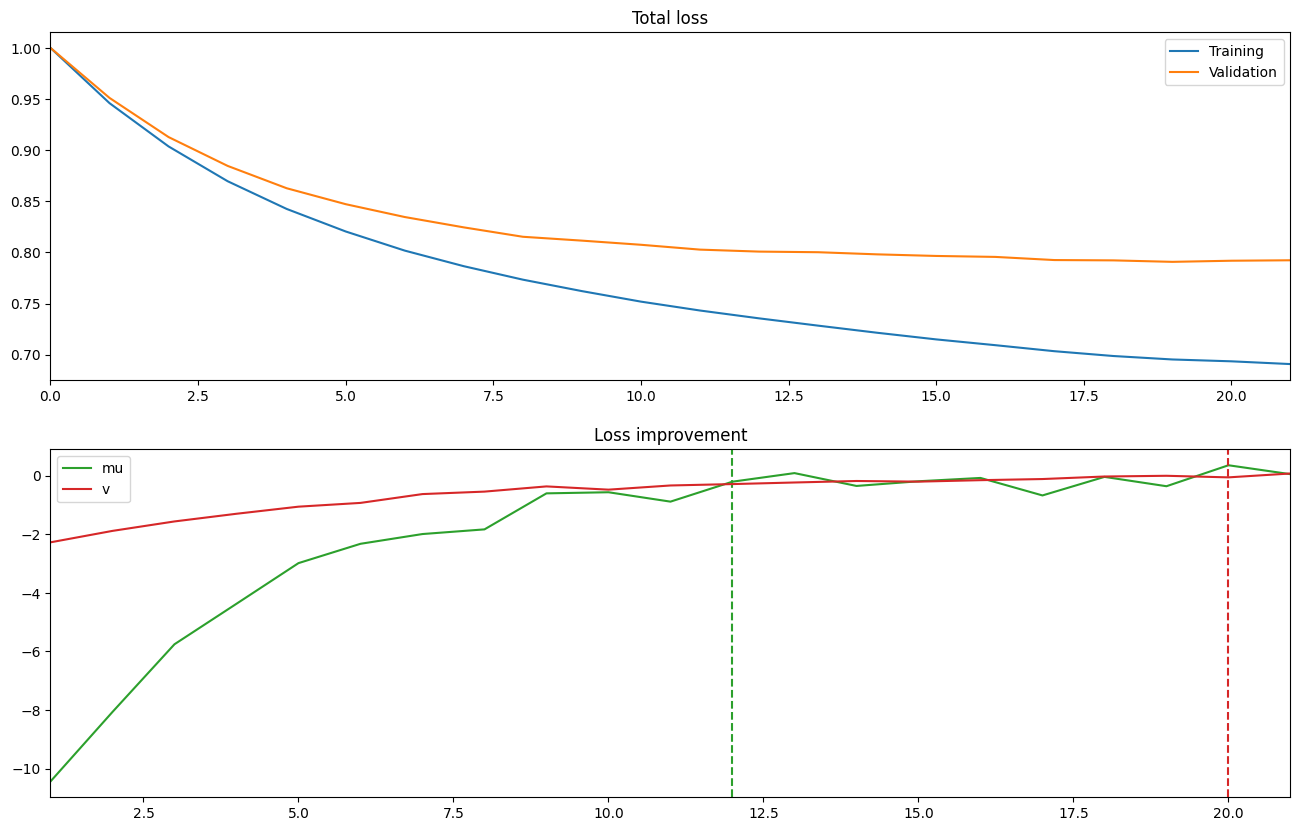

In [3]:
# Set hyperparameters
BMax = kappa_max
nFolds = n_splits
d = 2
epsilon = [eps] * d

from scipy.special import loggamma as lg
from scipy.special import polygamma as pg


# Loss function
def lossEval(z, y):
    mu = np.exp(z[0])
    v = np.exp(z[1])
    loss = (
        (mu + v + mu * v) * np.log(y + 1)
        - mu * (v + 1) * np.log(y)
        + lg(mu * (v + 1))
        + lg(v + 2)
        - lg(mu + v + mu * v + 2)
    )
    return loss


# Gradients
def grad0(z, y):
    # Parameter values
    mu = np.exp(z[0])
    v = np.exp(z[1])
    # Calulate gradient
    grad = (
        mu
        * (1 + v)
        * (pg(0, mu * (1 + v)) - pg(0, mu + v + mu * v + 2) + np.log((1 + y) / y))
    )
    return grad


def grad1(z, y):
    # Parameter values
    mu = np.exp(z[0])
    v = np.exp(z[1])
    # Calulate gradient
    grad = v * (
        mu * np.log((y + 1) / y)
        + np.log(y + 1)
        + mu * pg(0, mu * (v + 1))
        + pg(0, v + 2)
        - (mu + 1) * pg(0, mu * (v + 1) + v + 2)
    )
    return grad


# Gradient list
grads = [grad0, grad1]

param_names = ["mu", "v"]

kf = KFold(n_splits=nFolds, shuffle=True, random_state=random_state)

# Tree fitting
from sklearn.tree import DecisionTreeRegressor as regressionTree


def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    g = grad(z, y)
    tree.fit(x, -g)
    return tree


# Local tree training function
def trainThisTree(
    z, y, x, grad, max_depth=max_depth, min_samples_leaf=min_samples_leaf
):
    return trainTree(z, y, x, grad, max_depth, min_samples_leaf)


# Evaluation arrays (indexed by fold, boosting step)
lossTrain, lossValid = np.zeros((nFolds, BMax, d)), np.zeros((nFolds, BMax, d))

# Dimension indicator for score adding
e = [np.stack([[0]] * j + [[1]] + [[0]] * (d - j - 1)) for j in range(0, d)]

# Intercept model
xTrain, yTrain = X, y
nTrain = len(yTrain)

toMin = lambda z: lossEval(z, yTrain).sum()
zOpt = minimize(toMin, np.zeros(d))["x"]

# Fit to all folds
for i, idx in enumerate(kf.split(X)):
    # Training and validation data
    idx_train, idx_valid = idx
    xTrain, yTrain = X[idx_train], y[idx_train]
    xValid, yValid = X[idx_valid], y[idx_valid]
    nTrain, nValid = len(yTrain), len(yValid)

    # Initiate score
    zTrain = zOpt.repeat(nTrain).reshape((d, nTrain))
    zValid = zOpt.repeat(nValid).reshape((d, nValid))

    # Initiate loss
    for j in range(0, d):
        lossTrain[i, 0, j] = lossEval(zTrain, yTrain).sum()
        lossValid[i, 0, j] = lossEval(zValid, yValid).sum()

    # Build trees
    for b in range(1, BMax):
        # For all parameter dimensions
        for j in range(0, d):
            # Fit a tree
            tree = trainThisTree(zTrain, yTrain, xTrain, grads[j])

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for k, nodeValue in enumerate(nodeValues):
                # Indices with this node value
                indicesTrain = zTrainPlus == nodeValue
                indicesValid = zValidPlus == nodeValue
                # Optimize step size
                gammaOpt = minimize(
                    lambda gamma: lossEval(
                        zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                    ).sum(),
                    jac=lambda gamma: (
                        grad0(
                            zTrain[:, indicesTrain] + e[0] * gamma, yTrain[indicesTrain]
                        )
                    ).sum(),
                    x0=nodeValue,
                )["x"][0]
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j] * zTrainPlus
            zValid[j] += epsilon[j] * zValidPlus

            # Update loss
            lossTrain[i, b, j] = lossEval(zTrain, yTrain).sum()
            lossValid[i, b, j] = lossEval(zValid, yValid).sum()

        # Check breaking criteria
        if (
            lossValid[i, b, 0] > lossValid[i, b - 1, 1]
            and lossValid[i, b, 1] > lossValid[i, b, 0]
        ):
            lossTrain[i, b + 1 :, :] = lossTrain[i, b, -1]
            lossValid[i, b + 1 :, :] = lossValid[i, b, -1]
            break

# Sum the losses
lossTrainTot = lossTrain.sum(axis=0)[:, -1]
lossValidTot = lossValid.sum(axis=0)[:, -1]

# Calculate loss improvements
lossValidPerUpdate = lossValid.sum(axis=0)
lossImprovement = np.zeros((BMax, d))
lossImprovement[1:, 0] = lossValidPerUpdate[1:, 0] - lossValidPerUpdate[:-1, 1]
lossImprovement[1:, 1] = lossValidPerUpdate[1:, 1] - lossValidPerUpdate[1:, 0]

# Pick optimal number of boosters
BOpts = np.argmax(lossImprovement[1:] > 0, axis=0)
BOpt = int(max(BOpts))
[print(f"BOpt {param_names[j]}: {int(BOpts[j])}") for j in range(0, d)]

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(16, 16 / 1.61))

# Show validation losses
axs[0].plot(lossTrainTot[: BOpt + 2] / np.abs(lossTrainTot[0]), label="Training")
axs[0].plot(lossValidTot[: BOpt + 2] / np.abs(lossValidTot[0]), label="Validation")
axs[0].legend()
axs[0].set_title("Total loss")
axs[0].set_xlim([0, BOpt + 1])

# Show loss improvements
colors = ["tab:green", "tab:red"]
for j in range(0, d):
    axs[1].plot(
        np.arange(1, BOpt + 3),
        lossImprovement[1 : BOpt + 3, j],
        label=param_names[j],
        color=colors[j],
    )
    axs[1].axvline(BOpts[j], linestyle="--", color=colors[j])

axs[1].legend()
axs[1].set_title("Loss improvement")
axs[1].set_xlim([1, BOpt + 1]);

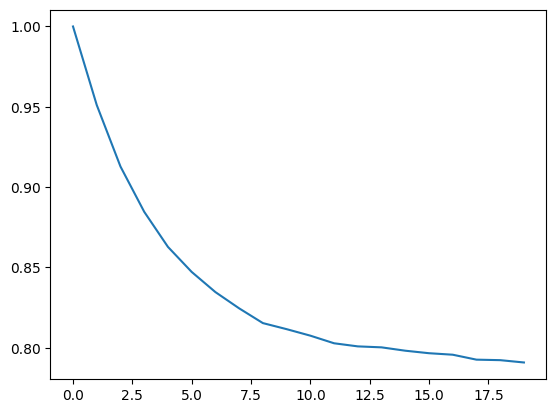

In [6]:
plt.plot(lossValidTot[:20] / lossValidTot[0])

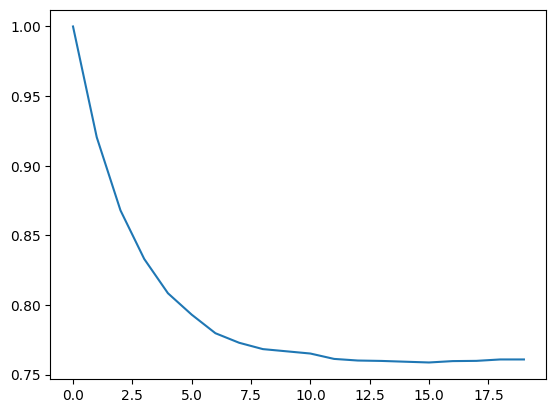

In [7]:
loss_total = loss.sum(axis=0)[:, -1]
plt.plot(loss_total[:20] / loss_total[0])